# Appendix: Different methods of matching tracks to tracks

A necessary step is to check that track-to-track matching works fine for different thresholds and how sensitive it is from run to run.

In [1]:
from datetime import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Rectangle
# import matplotlib.cm as mcm
import numpy as np
import pandas as pd

from arke.cart import lcc_map

from common_defs import winters, nyr, winter_dates, datasets, aliases, conf_key_typeset, _runs_grid_formatter, bbox
from match_to_stars import match_options, _make_match_label, prepare_stars
import mypaths
from plot_utils import heatmap, annotate_heatmap

from octant.core import TrackRun
import octant
octant.__version__

'v0.0.21+0.g96be4b6.dirty'

## Load preprocessed data

First we load the dictionary of settings used in sensitivity runs.

In [2]:
with (mypaths.procdir / 'runs_grid.json').open('r') as f:
    runs_grid = json.load(f)

Next, we load the output of `match_to_stars.py`, namely text files with IDs of tracked cyclone and corresponding IDs of STARS cyclones that match to each other.

Exactly 100 STARS tracks are used, so the numbers in the plot below are equivalent to %.

In [3]:
matrices = {}
for dataset in datasets:
    matrix = np.zeros((len(match_options), len(runs_grid)))
    for match_i, match_option in enumerate(match_options):
        for run_id, run_dict in enumerate(runs_grid):
            df = pd.read_csv(mypaths.procdir/'matches'/f'{dataset}_run{run_id:03d}_2000_2018_{_make_match_label(match_option)}.txt',
                             skiprows=4, names=['pmc', 'stars'])
            matrix[match_i, run_id] = df.shape[0]
    matrices[dataset] = matrix

Create labels for X- and Y-axis.

In [4]:
m_labels = [_make_match_label(match_option, '\n') for match_option in match_options]
r_labels = [_runs_grid_formatter(run_dict) for run_dict in runs_grid]
r_labels = [i.split('\n')[0] for i in r_labels]  # leave only top row

## Plot results for ERA5 and ERA-Interim

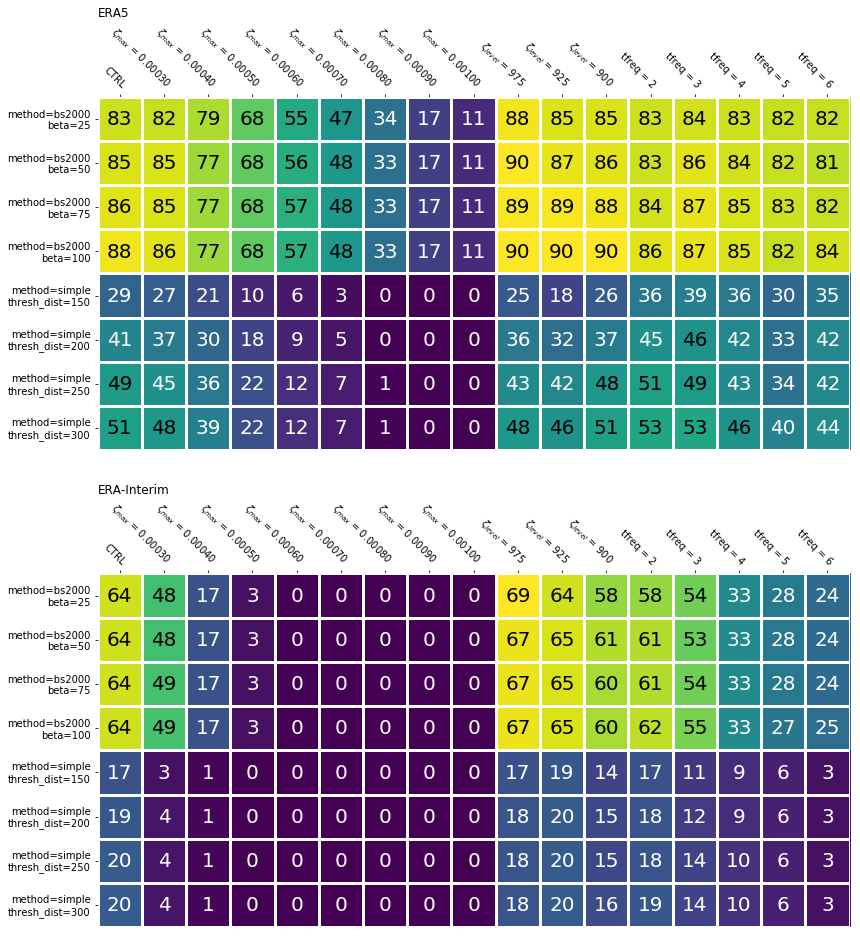

In [5]:
fig, axs = plt.subplots(figsize=(12, 7*len(datasets)), nrows=len(datasets))

for ax, dataset in zip(axs, datasets):
    ax.set_title(aliases[dataset], loc='left', pad=80)
    im, cbar = heatmap(matrices[dataset], m_labels, r_labels, ax=ax,
                       cmap="viridis")
    cbar.remove()
    texts = annotate_heatmap(im, valfmt="{x:.0f}", fontsize=20, textcolors=['w', 'k'])
fig.tight_layout()

## Findings

### Performance of matching methods

* The "bs2000" method (top 4 rows) is much more robust to changes in tracking parameters (from run to run, along X-axis) in ERA5 runs, as the top right quadrant of the top plot shows - all values fluctuate around 85.
* The numbers also change very little between the top 4 rows, demonstrating the robustness with respect to the `beta` parameter (i.e. the "weight" of time match between tracks).
* On the other hand, the method may appear too insentive and biased towards overestimation of track-to-track matches, hiding small differences between tracking runs.


* The "simple" method (bottom 4 rows) shows less consistency and is more sensitive both to tracking parameters (X-axis) and its own parameter ("thresh_dis", Y-axis).
* The latter makes it especially undesirable to use: depending on the threshold the ERA5-CTRL match rate can differ by almost 40%.
* This method generally yeilds worse match rates.


* Unsurprisingly, a much larger sensitivity to the $\zeta_{max}$ threshold is visible - this is exlored in more detail in the main [notebook](Verification.ipynb).

### Time frequency

* ERA5 tracking results show surprisingly low sensitivity to the time frequency.
* Tracking done at 2 or 3 h frequency yields basically the same match rate, especially when the "bs2000" method is used.
* There is a local dip at `tfreq=5` (every 5h) - data assimilation issue?


* For ERA-Interim, the match rates drop faster with `tfreq`, because the base frequency is 3 h, and increasing this parameter leads to time steps of 6 h, 9 h, 12 h, 15 h, and 18 h (not equivalent to ERA5!).


* This needs to be investigated further...

## Explore individual tracks

In [2]:
from ipywidgets import interact

In [3]:
stars_tracks = prepare_stars(bbox)

In [8]:
# df0 = pd.read_csv(mypaths.procdir/'matches'/f'{dataset}_run000_2000_2018_{_make_match_label(match_options[3])}.txt',
#                          skiprows=4, names=['pmc', 'stars'])

# tr0 = TrackRun.from_archive(mypaths.procdir / f'{dataset}_run000_2000_2018.h5')

# df = pd.read_csv(mypaths.procdir/'matches'/f'{dataset}_run016_2000_2018_{_make_match_label(match_options[3])}.txt',
#                          skiprows=4, names=['pmc', 'stars'])

# tr = TrackRun.from_archive(mypaths.procdir / f'{dataset}_run016_2000_2018.h5')

In [9]:
# @interact(i=[x.N.values[0] for x in stars_tracks])
# def fn(i):
#     fig, ax = plt.subplots(figsize=(15, 8))
#     ax.set_xlim(bbox[:2])
#     ax.set_ylim(bbox[2:])
#     [x for x in stars_tracks if x.N[0]==i][0].plot_track(ax=ax, color='C0', marker='o', ms=10)
#     try:
#         tr0['pmc'].loc[df0[df0.stars==i].pmc.values[0]].plot_track(ax=ax, color='C1', marker='o', alpha=0.75, ms=8)
#     except IndexError:
#         pass
#     try:
#         tr['pmc'].loc[df[df.stars==i].pmc.values[0]].plot_track(ax=ax, color='C2', marker='o', alpha=0.5)
#     except IndexError:
#         pass